In [1]:
from google.colab import drive

try:
    MOUNTED
except NameError as e:
    drive.mount('/gdrive')
    MOUNTED = True

Mounted at /gdrive


In [5]:
pip install konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 47.5MB/s 
     |████████████████████████████████| 92kB 8.2MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [6]:
import pandas as pd
import numpy as np
%matplotlib inline
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import json
import os
from pprint import pprint
import matplotlib.pyplot as plt
import re
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models
from keras import layers
from keras import Sequential
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras


#train_data_senti.csv/test_data_senti.csv 사용하여 모델학습
path_name1 = '영화감성분석'
path_name2_init = '감성영화데이터'
okt = Okt()
path='../gdrive/My Drive/데이터마이닝/'
df_all = pd.read_csv(path + path_name1 + '/' + path_name2_init + '.csv')
train_data = pd.read_csv(path + 'train_data_senti.csv')
test_data = pd.read_csv(path + 'test_data_senti.csv')

In [8]:
df_all['리뷰내용'].nunique(), df_all['카테고리'].nunique()

(15044, 2)

In [9]:
df_all.drop_duplicates(subset=['리뷰내용'], inplace=True)

In [10]:
print('총 샘플의 수 :',len(df_all))
train_data=df_all[['리뷰내용','카테고리']]

총 샘플의 수 : 15044


   카테고리  count
0     0   3088
1     1  11956


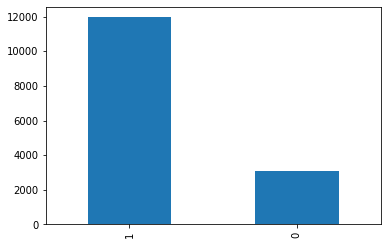

In [11]:
train_data['카테고리'].value_counts().plot(kind = 'bar')
print(train_data.groupby('카테고리').size().reset_index(name = 'count'))

In [12]:
print(train_data.isnull().values.any())

False


In [13]:
print(train_data.isnull().sum())

리뷰내용    0
카테고리    0
dtype: int64


In [14]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [15]:
train_data.head()

,리뷰내용,카테고리
0,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,1
1,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,1
2,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,1
3,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,1
4,\n\n\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,1


In [16]:
train_data['리뷰내용'] = train_data['리뷰내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,리뷰내용,카테고리
0,광활한 대자연과 미칠듯한 브래드피트형의 매력 다들 이렇게 게이가 되어가나,1
1,누구나 가지고 싶지만 누구도 가질 수 없는 남자 아름답지만 너무 거칠고 선하지만 스...,1
2,극중에서 알프레드가 가장 인간적이고 정상적인 캐릭터인듯,1
3,이때 진짜 말이안되는 최최강 역대급 미모 브래드형 주의에 여자들까지 전부 오징어로 ...,1
4,형제간의 모든 반목과 상처를 결국 용서와 화해로 끌어안는 알프레드의 모습 그의 쓸쓸...,1


In [17]:
train_data['리뷰내용'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

리뷰내용    1
카테고리    0
dtype: int64


In [18]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

15043


In [19]:
df_dataset = train_data

In [20]:
train_data, test_data = train_test_split(df_dataset, test_size=0.3, shuffle=True, random_state=77)

In [21]:
test_data.drop_duplicates(subset = ['리뷰내용'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['리뷰내용'] = test_data['리뷰내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['리뷰내용'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 4501


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [23]:
# train_data.to_csv(path + "train_data_senti.csv",encoding="utf-8-sig",mode='w',index=False)
# test_data.to_csv(path + "test_data_senti.csv",encoding="utf-8-sig",mode='w',index=False)

In [24]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [25]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [26]:
X_train = []
for sentence in train_data['리뷰내용']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [27]:
print(X_train[:3])

[['주인공', '인', '줄', '알다', '애', '순삭', '되다', '때', '부터', '몰입', '되다', 'ㅋㅋ', '빠르다', '전개', '로', '세상', '불편', '충', '치다', '죽이다', '영화'], ['크다', '언니', '진짜', '멋있다', '사람', '이다', 'ㅜㅜ', '크다', '스토리', '없다', '일본', '정서', '많이', '묻다', '영상', '미가', '정말', '뛰어나다', '내내', '감탄', '색감', '정말', '예쁘다'], ['여자', '너무', '안', '이쁘다', 'ㅋㅋ']]


In [28]:
X_test = []
for sentence in test_data['리뷰내용']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [31]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '있다': 4, '이다': 5, '적': 6, '좋다': 7, '되다': 8, '없다': 9, '너무': 10, '사랑': 11, '같다': 12, '않다': 13, '것': 14, '다': 15, '그': 16, '정말': 17, '에서': 18, '연기': 19, '사람': 20, '아니다': 21, '로': 22, '진짜': 23, '생각': 24, '내': 25, '인': 26, '때': 27, '감동': 28, '수': 29, '만': 30, '최고': 31, '나': 32, '더': 33, '관람객': 34, '보고': 35, '자다': 36, '고': 37, '다시': 38, '게': 39, '말': 40, '재밌다': 41, '못': 42, '마지막': 43, '배우': 44, '장면': 45, '안': 46, '하고': 47, '만들다': 48, '나오다': 49, '인생': 50, '점': 51, '이렇다': 52, '현실': 53, '싶다': 54, '아름답다': 55, '모르다': 56, '중': 57, '까지': 58, '마음': 59, '가다': 60, '왜': 61, '년': 62, '많다': 63, '여자': 64, '들다': 65, '에게': 66, '알다': 67, '오다': 68, '느끼다': 69, '지금': 70, '명작': 71, '평점': 72, '그리고': 73, '그렇다': 74, '요': 75, '나다': 76, '슬프다': 77, '가슴': 78, '남자': 79, '이해': 80, '먹다': 81, '주다': 82, '남다': 83, '시간': 84, '하나': 85, '처음': 86, '눈물': 87, '이야기': 88, '아': 89, '감독': 90, '주인공': 91, '공감': 92, '그냥': 93, '스토리': 94, '네': 95, '지': 96, '해주다': 97, '느낌': 98, '볼': 99, '우리': 100, '기억': 101, 'ㅠㅠ':

In [32]:
threshold = 1
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11240
등장 빈도가 0번 이하인 희귀 단어의 수: 0
단어 집합에서 희귀 단어의 비율: 0.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.0


In [33]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 11242


In [34]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [35]:
print(X_train[:3])

[[92, 27, 223, 68, 241, 4698, 9, 28, 195, 227, 9, 144, 1782, 342, 23, 147, 2564, 1404, 368, 461, 2], [168, 2290, 24, 457, 21, 6, 356, 168, 95, 10, 480, 1056, 112, 791, 244, 1405, 18, 899, 166, 706, 1406, 18, 264], [65, 11, 47, 272, 144]]


In [36]:
y_train = np.array(train_data['카테고리'])
y_test = np.array(test_data['카테고리'])

In [38]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [39]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

10473
10473


리뷰의 최대 길이 : 50
리뷰의 평균 길이 : 13.650147999618065


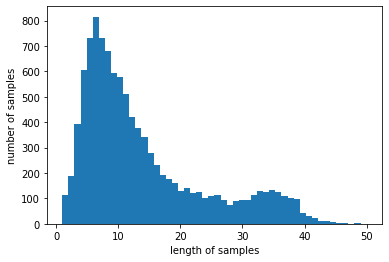

In [40]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [41]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [42]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 99.112002291607


In [43]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [44]:
model = tf.keras.models.Sequential([
    keras.layers.Embedding(vocab_size, 100),
    keras.layers.LSTM(128),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
  ])

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size, 100))
# model.add(LSTM(128))
# model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(path + 'best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
140/140 [==============================] - ETA: 0s - loss: 0.4710 - acc: 0.7929
Epoch 00001: val_acc improved from -inf to 0.84296, saving model to ../gdrive/My Drive/데이터마이닝/best_model.h5
140/140 [==============================] - 15s 107ms/step - loss: 0.4710 - acc: 0.7929 - val_loss: 0.3602 - val_acc: 0.8430
Epoch 2/15
140/140 [==============================] - ETA: 0s - loss: 0.2980 - acc: 0.8806
Epoch 00002: val_acc improved from 0.84296 to 0.86730, saving model to ../gdrive/My Drive/데이터마이닝/best_model.h5
140/140 [==============================] - 14s 100ms/step - loss: 0.2980 - acc: 0.8806 - val_loss: 0.3405 - val_acc: 0.8673
Epoch 3/15
140/140 [==============================] - ETA: 0s - loss: 0.2402 - acc: 0.9050
Epoch 00003: val_acc improved from 0.86730 to 0.87399, saving model to ../gdrive/My Drive/데이터마이닝/best_model.h5
140/140 [==============================] - 14s 100ms/step - loss: 0.2402 - acc: 0.9050 - val_loss: 0.3203 - val_acc: 0.8740
Epoch 4/15
140/140 [=====

In [45]:
loaded_model = tf.keras.models.load_model(path + 'best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

141/141 [==============================] - 2s 15ms/step - loss: 0.3369 - acc: 0.8674

 테스트 정확도: 0.8674


In [ ]:
# def sentiment_predict(new_sentence):
#   new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
#   new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
#   encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
#   pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
#   score = float(loaded_model.predict(pad_new)) # 예측
#   if(score > 0.5):
#     print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
#   else:
#     print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
max_len = 40
def sentiment_predict(df_new_sentence):
  new_sentence = df_new_sentence['리뷰내용']
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    df_new_sentence['감성점수'] = score*100
  else:
    df_new_sentence['감성점수'] = 100-((1 - score) * 100)

  return df_new_sentence

In [ ]:
# sentiment_predict('화성 연쇄 살인사건 범인도 잡혔는데.. 이 사건도 범인을 잡았으면..')

TypeError: ignored

In [ ]:
# sentiment_predict('곧 이것도 잡혀야 할텐데')

# **수집한 영화데이터에 감성점수 매기기**

In [ ]:
df_testset = pd.read_csv(path + '무작위영화데이터.csv')

In [ ]:
df_testset = df_testset.drop(['Unnamed: 0'],axis=1)

In [ ]:
df_testset.head()

,별점,리뷰내용,작성자,작성일자,공감,비공감,영화제목,카테고리,장르,감독,상영시간,영화평점
0,10,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,너프(elun****),2013.07.20 01:32,6084,189,아저씨,test,"\n액션, \n\t\t\t\t\t\n\t\t\t\t\n\t\t\t\t\t\n\t\t...",이정범,119분,9.24
1,9,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,OnlyOne(lady****),2013.07.09 03:08,3446,89,아저씨,test,"\n액션, \n\t\t\t\t\t\n\t\t\t\t\n\t\t\t\t\t\n\t\t...",이정범,119분,9.24
2,6,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,진시황제(seyi****),2013.07.22 09:13,2756,263,아저씨,test,"\n액션, \n\t\t\t\t\t\n\t\t\t\t\n\t\t\t\t\t\n\t\t...",이정범,119분,9.24
3,10,\n\n\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,gura****,2013.06.18 01:59,2416,130,아저씨,test,"\n액션, \n\t\t\t\t\t\n\t\t\t\t\n\t\t\t\t\t\n\t\t...",이정범,119분,9.24
4,10,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,dmal****,2013.07.07 02:56,2266,64,아저씨,test,"\n액션, \n\t\t\t\t\t\n\t\t\t\t\n\t\t\t\t\t\n\t\t...",이정범,119분,9.24


In [ ]:
df_testset['리뷰내용'] = df_testset['리뷰내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_testset['장르'] = df_testset['장르'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_testset[:5]

,별점,리뷰내용,작성자,작성일자,공감,비공감,영화제목,카테고리,장르,감독,상영시간,영화평점
0,10,성 정체성이 흔들렸다,너프(elun****),2013.07.20 01:32,6084,189,아저씨,test,액션 범죄 드라마,이정범,119분,9.24
1,9,스토리든 뭐든 원빈의 눈빛이 모든걸 덮었다,OnlyOne(lady****),2013.07.09 03:08,3446,89,아저씨,test,액션 범죄 드라마,이정범,119분,9.24
2,6,영화 제목을 원빈으로 바꿔라,진시황제(seyi****),2013.07.22 09:13,2756,263,아저씨,test,액션 범죄 드라마,이정범,119분,9.24
3,10,은위 보고 아저씨 생각나서 다시 보고 평점 남긴다 일단 은위가 걍 아저씨 액션 따라...,gura****,2013.06.18 01:59,2416,130,아저씨,test,액션 범죄 드라마,이정범,119분,9.24
4,10,한국영화는 두번이상 본게 없는데 아저씬 몇십번을 봐도 잼난다 ㅋ,dmal****,2013.07.07 02:56,2266,64,아저씨,test,액션 범죄 드라마,이정범,119분,9.24


In [ ]:
df_testset.head()

,별점,리뷰내용,작성자,작성일자,공감,비공감,영화제목,카테고리,장르,감독,상영시간,영화평점
0,10,성 정체성이 흔들렸다,너프(elun****),2013.07.20 01:32,6084,189,아저씨,test,액션 범죄 드라마,이정범,119분,9.24
1,9,스토리든 뭐든 원빈의 눈빛이 모든걸 덮었다,OnlyOne(lady****),2013.07.09 03:08,3446,89,아저씨,test,액션 범죄 드라마,이정범,119분,9.24
2,6,영화 제목을 원빈으로 바꿔라,진시황제(seyi****),2013.07.22 09:13,2756,263,아저씨,test,액션 범죄 드라마,이정범,119분,9.24
3,10,은위 보고 아저씨 생각나서 다시 보고 평점 남긴다 일단 은위가 걍 아저씨 액션 따라...,gura****,2013.06.18 01:59,2416,130,아저씨,test,액션 범죄 드라마,이정범,119분,9.24
4,10,한국영화는 두번이상 본게 없는데 아저씬 몇십번을 봐도 잼난다 ㅋ,dmal****,2013.07.07 02:56,2266,64,아저씨,test,액션 범죄 드라마,이정범,119분,9.24


In [ ]:
df_testset.drop_duplicates(subset=['리뷰내용'], inplace=True)
df_testset.reset_index(inplace=True)

In [ ]:
len(df_testset)

67504

In [ ]:
#한글폰트 설치

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.font_manager as fm  # 폰트 관련 용도

In [ ]:
# 체크해보면 폰트 개수가 늘어났다
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

sys_font number: 48
nanum_font number: 31


In [ ]:
nanum_font

In [ ]:
df_testset

,index,별점,리뷰내용,작성자,작성일자,공감,비공감,영화제목,카테고리,장르,감독,상영시간,영화평점
0,0,10,성 정체성이 흔들렸다,너프(elun****),2013.07.20 01:32,6084,189,아저씨,test,액션 범죄 드라마,이정범,119분,9.24
100,100,8,아메리카 마인드 또라이 두명이 스크린을 휘저어놓는다 근데 왠지 남 얘기같지 않다 영...,85yo****,2013.07.20 15:07,768,139,실버라이닝 플레이북,test,코미디 드라마 멜로로맨스,데이비드 O. 러셀,122분,8.60
200,200,10,이 영화의 아름다움을 영원히 느끼지 못하고 평점테러중인 호모포비아들이 애잔함,수정 유(hwer****),2018.03.22 17:52,3701,1043,콜 미 바이 유어 네임,test,드라마 멜로로맨스,루카 구아다니노,132분,7.89
300,300,4,김규리 배우 연기 정말 부족하네요 다른 주 조연 분들은 연기 잘하시는데 혼자 아침드...,Deviant(gyeo****),2019.05.16 21:10,5875,1801,악인전,test,범죄 액션,이원태,110분,7.88
400,400,10,박화영의 캐릭터를 연기한 김가희 배우님께 박수를 보냅니다 그리고 영화 속 화영이에게...,김륜이(fbsd****),2018.07.28 15:26,1879,67,박화영,test,드라마,이환,99분,7.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67007,78595,4,나만 이해못했나봐아직도 마사지 하는 춤춘애는 왜나온건지같이 산책하던 여자앤 누군지 ...,여자사람(tlst****),2016.01.08 20:11,198,80,유스,영화데이터,드라마,파올로 소렌티노,124분,8.34
67106,78795,10,몇분이서 오셨어요 와저씨 한명이요,ckj(pck9****),2016.06.09 00:14,2572,183,워크래프트: 전쟁의 서막,영화데이터,액션 모험 판타지,던칸 존스,122분,8.66
67205,78895,10,이것이 한국 토속 신앙이다 우리가 부정했지만 불안할때마다 기댔던 신앙의 보고서,시리우스(sols****),2014.03.07 17:18,384,55,만신,영화데이터,다큐멘터리 드라마,박찬경,104분,8.04
67304,79095,10,사람 이병헌은 별로인데 연기자 이병헌은 최고다 인정,avernbc(fkfk****),2015.11.19 00:05,11200,913,내부자들,test,범죄 드라마,우민호,130분,9.00


In [ ]:
df_movietitle = df_testset
df_movietitle.drop_duplicates(subset=['영화제목'], inplace=True)

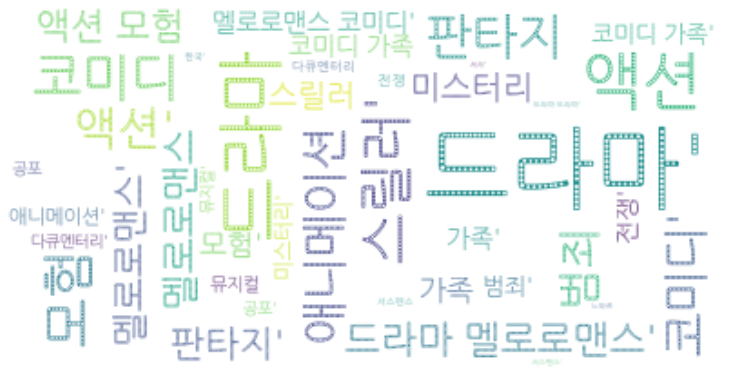

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = list(df_testset['장르'])
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(font_path ='/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf', max_font_size=50, max_words=100,background_color="white").generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
len(df_testset.loc[1])

12

In [ ]:
# tmp = []
# for i in range(len(df_testset)):
#   tmp.append(sentiment_predict(df_testset.loc[i]))
# df_tmp = pd.DataFrame(tmp)
# df_tmp = df_tmp.drop(['index'],axis=1)
# df_tmp.to_csv(path + "추천영화데이터_감성점수.csv",encoding="utf-8-sig",mode='w',index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while w

In [ ]:
df_sentiscore=pd.read_csv(path + "추천영화데이터_감성점수.csv")

In [ ]:
# avg_tmp = []
# for i in df_movietitle["영화제목"]:
#   avg = 0
#   avg = df_sentiscore[df_sentiscore["영화제목"]==i]["감성점수"].mean()
#   avg_tmp.append(avg)
# df_avg = pd.DataFrame({"감성점수평균":avg_tmp})

In [ ]:
df_recommend = df_movietitle
df_recommend = df_recommend.drop(['index'],axis=1)
df_recommend = df_recommend.drop(['리뷰내용'],axis=1)
df_recommend = df_recommend.drop(['작성자'],axis=1)
df_recommend = df_recommend.drop(['작성일자'],axis=1)
df_recommend = df_recommend.drop(['공감'],axis=1)
df_recommend = df_recommend.drop(['비공감'],axis=1)
df_recommend = df_recommend.drop(['카테고리'],axis=1)
df_recommend = df_recommend.drop(['별점'],axis=1)
df_recommend.reset_index(inplace=True)

In [ ]:
df_recommend = pd.read_csv(path + "추천영화데이터_감성평균.csv")
df_recommend = pd.concat([df_recommend, df_weightavg], axis = 1)
# df_recommend = df_recommend.drop(['index'],axis=1)

KeyError: ignored

In [ ]:
df_recommend.to_csv(path + "추천영화데이터_단순+가중평균.csv",encoding="utf-8-sig",mode='w',index=False)

In [ ]:
df_recommend[df_recommend["감성점수가중평균"]<=0]

,영화제목,장르,감독,상영시간,영화평점,감성점수평균,감성점수가중평균
281,Jam Docu 강정,다큐멘터리,경순,104분,4.78,60.504094,-53.464753


In [ ]:
# df_recommend.to_csv(path + "추천영화데이터_감성평균.csv",encoding="utf-8-sig",mode='w',index=False)

In [ ]:
df_sentiscore

,별점,리뷰내용,작성자,작성일자,공감,비공감,영화제목,카테고리,장르,감독,상영시간,영화평점,감성점수
0,10,성 정체성이 흔들렸다,너프(elun****),2013.07.20 01:32,6084,189,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,18.362972
1,9,스토리든 뭐든 원빈의 눈빛이 모든걸 덮었다,OnlyOne(lady****),2013.07.09 03:08,3446,89,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,99.095136
2,6,영화 제목을 원빈으로 바꿔라,진시황제(seyi****),2013.07.22 09:13,2756,263,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,94.058299
3,10,은위 보고 아저씨 생각나서 다시 보고 평점 남긴다 일단 은위가 걍 아저씨 액션 따라...,gura****,2013.06.18 01:59,2416,130,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,90.796179
4,10,한국영화는 두번이상 본게 없는데 아저씬 몇십번을 봐도 잼난다 ㅋ,dmal****,2013.07.07 02:56,2266,64,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,45.769954
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67499,1,와 로리타네 그냥 늙어도 탐하면 안되는게 어린아이이다 포장하지 마라 아름답다 하지마...,yswy****,2019.07.15 14:16,26,5,은교,test,멜로로맨스,정지우,129분,7.06,97.044927
67500,1,더럽다 영화를 보면서 속이 메쓰꺼운건 처음,Nyaha R(suru****),2019.08.01 00:49,21,1,은교,test,멜로로맨스,정지우,129분,7.06,41.921538
67501,10,은교 재평가의 시간 ㅎㄷ ㄷ ㄷ ㄷ폭로가 담긴 영화였다니 ㅋㅋㅋ 사실은 전부 노시인...,또또(imqt****),2018.02.27 16:38,28,8,은교,test,멜로로맨스,정지우,129분,7.06,68.573743
67502,9,사랑하지만 현실은 키다리 아저씨가 될 수 밖에 없는 늙은 시인의 여고생을 향한 사랑...,TYUILO(coco****),2013.06.21 09:48,43,23,은교,test,멜로로맨스,정지우,129분,7.06,95.283359


In [ ]:

from tqdm import tqdm_notebook

In [ ]:
df_movietitle = pd.read_csv(path + "추천영화데이터_감성점수.csv")
df_movietitle.drop_duplicates(subset=['영화제목'], inplace=True)

In [ ]:
avg_tmp = []
for i in tqdm_notebook(df_movietitle["영화제목"]):
  avg = 0
  score_sum = 0
  weight_sum = 0
  for j in df_sentiscore[df_sentiscore["영화제목"]==i].index:
    good = df_sentiscore[df_sentiscore["영화제목"]==i]["공감"][j]
    bad = df_sentiscore[df_sentiscore["영화제목"]==i]["비공감"][j]
    score = df_sentiscore[df_sentiscore["영화제목"]==i]["감성점수"][j]
    weight = good - bad
    score_sum = score_sum + weight*score
    weight_sum = weight_sum + abs(weight)
  avg = score_sum / weight_sum
  avg_tmp.append(avg)
df_weightavg = pd.DataFrame({"감성점수가중평균":avg_tmp})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
df_weightavg = pd.DataFrame({"감성점수가중평균":avg_tmp})

In [ ]:
df_sentiscore[df_sentiscore["영화제목"]=="아저씨"]

,별점,리뷰내용,작성자,작성일자,공감,비공감,영화제목,카테고리,장르,감독,상영시간,영화평점,감성점수
0,10,성 정체성이 흔들렸다,너프(elun****),2013.07.20 01:32,6084,189,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,18.362972
1,9,스토리든 뭐든 원빈의 눈빛이 모든걸 덮었다,OnlyOne(lady****),2013.07.09 03:08,3446,89,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,99.095136
2,6,영화 제목을 원빈으로 바꿔라,진시황제(seyi****),2013.07.22 09:13,2756,263,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,94.058299
3,10,은위 보고 아저씨 생각나서 다시 보고 평점 남긴다 일단 은위가 걍 아저씨 액션 따라...,gura****,2013.06.18 01:59,2416,130,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,90.796179
4,10,한국영화는 두번이상 본게 없는데 아저씬 몇십번을 봐도 잼난다 ㅋ,dmal****,2013.07.07 02:56,2266,64,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,45.769954
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10,원빈 인생작 평생이 리즈시절이구나,송새(3535****),2014.12.26 01:39,45,0,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,99.190819
96,10,잔혹함과 감동은 궁합이 맞지 않다는 고정관념을 깨는 몇 안되는 영화 중 하나 가족을...,몽글(mong****),2014.04.29 16:26,46,1,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,96.603703
97,10,언제봐도 재미잇네,입문(ehwl****),2013.07.04 02:36,46,1,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,95.582443
98,10,난 번 넘게봐따항상 볼때마다 소름,dong****,2014.09.28 23:55,45,1,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,95.258224


In [ ]:
df_sentiscore

,별점,리뷰내용,작성자,작성일자,공감,비공감,영화제목,카테고리,장르,감독,상영시간,영화평점,감성점수
0,10,성 정체성이 흔들렸다,너프(elun****),2013.07.20 01:32,6084,189,아저씨,test,액션 범죄 드라마,이정범,119분,9.24,18.362972
100,8,아메리카 마인드 또라이 두명이 스크린을 휘저어놓는다 근데 왠지 남 얘기같지 않다 영...,85yo****,2013.07.20 15:07,768,139,실버라이닝 플레이북,test,코미디 드라마 멜로로맨스,데이비드 O. 러셀,122분,8.60,92.245555
200,10,이 영화의 아름다움을 영원히 느끼지 못하고 평점테러중인 호모포비아들이 애잔함,수정 유(hwer****),2018.03.22 17:52,3701,1043,콜 미 바이 유어 네임,test,드라마 멜로로맨스,루카 구아다니노,132분,7.89,93.226767
300,4,김규리 배우 연기 정말 부족하네요 다른 주 조연 분들은 연기 잘하시는데 혼자 아침드...,Deviant(gyeo****),2019.05.16 21:10,5875,1801,악인전,test,범죄 액션,이원태,110분,7.88,57.086480
400,10,박화영의 캐릭터를 연기한 김가희 배우님께 박수를 보냅니다 그리고 영화 속 화영이에게...,김륜이(fbsd****),2018.07.28 15:26,1879,67,박화영,test,드라마,이환,99분,7.72,21.241030
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67007,4,나만 이해못했나봐아직도 마사지 하는 춤춘애는 왜나온건지같이 산책하던 여자앤 누군지 ...,여자사람(tlst****),2016.01.08 20:11,198,80,유스,영화데이터,드라마,파올로 소렌티노,124분,8.34,96.749055
67106,10,몇분이서 오셨어요 와저씨 한명이요,ckj(pck9****),2016.06.09 00:14,2572,183,워크래프트: 전쟁의 서막,영화데이터,액션 모험 판타지,던칸 존스,122분,8.66,92.592794
67205,10,이것이 한국 토속 신앙이다 우리가 부정했지만 불안할때마다 기댔던 신앙의 보고서,시리우스(sols****),2014.03.07 17:18,384,55,만신,영화데이터,다큐멘터리 드라마,박찬경,104분,8.04,75.189853
67304,10,사람 이병헌은 별로인데 연기자 이병헌은 최고다 인정,avernbc(fkfk****),2015.11.19 00:05,11200,913,내부자들,test,범죄 드라마,우민호,130분,9.00,77.280891
